<h1> Book Recommender <h1><hr>
<h3> Purpose: </h3>
<p>The focus of this project is to build a simple and straightforward Book Recommender using similarity as our driver for suggestions</p>
<p> *This notebook will contain all Exploratory Data Analysis. </p>

<h3>Dataset:</h3>
<p> The dataset that will be used is the BX-Book datasets which is comprised of 3 datasets.<br><br> One of the datasets contains ratings which we will be using today to create a collaborative filtering recommendation system.<br> This will be done by using a K-Nearest Neighbor approach and evaluating a books relationship using Cosine Similarity from user's ratings of books.</p>

<p> *Future state I would like to use a hybrid approach by combining both collaborative and content-based filtering. In this scenario that can be a book's synopsis along with the user ratings.</p>

<h3> Table of Contents </h3>
<h5><ol>
    <li>Analyze the Dataset</li>
    <li>Prepare Data for Model Fit</li>
    <li>Fit a KNN model using Cosine Similarity & Evaluate</li>
</ol></h5>

# 1. Analyze the Dataset
<hr>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

book_rating_path = "./Datasets/BX-Book-Ratings.csv"
book_path = "./Datasets/BX-Books.csv"
book_user_path = "./Datasets/BX-Users.csv"

books = pd.read_csv(book_path, sep=';', on_bad_lines="skip", encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

users = pd.read_csv(book_user_path, sep=';', on_bad_lines="skip", encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv(book_rating_path, sep=';', on_bad_lines="skip", encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

/tmp/ipykernel_25165/3573324052.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(book_path, sep=';', on_bad_lines="skip", encoding="latin-1")


In [11]:
print(f"""Shape of Ratings:\n{ratings.shape} \n\nRatings Data Types: \n{ratings.dtypes} \n\nRatings DF:\n{ratings.head()}""")

Shape of Ratings:
(1149780, 3) 

Ratings Data Types: 
userID         int64
ISBN          object
bookRating     int64
dtype: object 

Ratings DF:
   userID        ISBN  bookRating
0  276725  034545104X           0
1  276726  0155061224           5
2  276727  0446520802           0
3  276729  052165615X           3
4  276729  0521795028           6


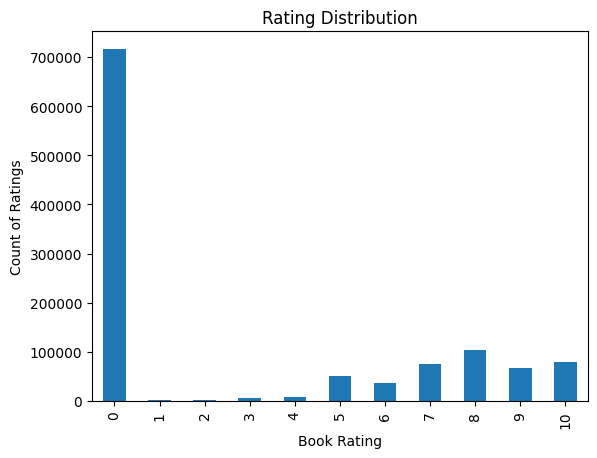

In [12]:
ratings['bookRating'].value_counts(sort=False).sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Book Rating')
plt.ylabel('Count of Ratings')
plt.show()

<h3> Finding: </h3>
<ol>
<li><p> If we look at the top ratings and the average rating per book. We can see that the 0-rating greatly influences that rating of a book. <br>
The top rated book has a rating of 1/10 which seems unlikely.</p></li>

<li><p>The top rated book is <i>Wild Animus</i> which when found on Amazon customer reviews shows a 3.5/5. If scaled to a 10 point rating that would be a 7/10. <br>
I'm also taking note of <i>The Lovely Bones: a Novel</i> which has a rating of 4.4/10 here, but on Amazon reviews it is 8.8/10</li>

This indicates to me that the 0-point ratings should be dropped to reduce size and improve reliability of the scores</p>

In [35]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
rating_count['averageRating'] = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].mean())
most_rated_books_summary = pd.merge(rating_count, books, on='ISBN')
most_rated_books_summary[most_rated_books_summary.columns[:5]].sort_values('bookRating',ascending=False).head()

,ISBN,bookRating,averageRating,bookTitle,bookAuthor
208183,0971880107,2502,1.019584,Wild Animus,Rich Shapero
37323,0316666343,1295,4.468726,The Lovely Bones: A Novel,Alice Sebold
68606,0385504209,883,4.652322,The Da Vinci Code,Dan Brown
7085,0060928336,732,3.448087,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
31282,0312195516,723,4.334716,The Red Tent (Bestselling Backlist),Anita Diamant


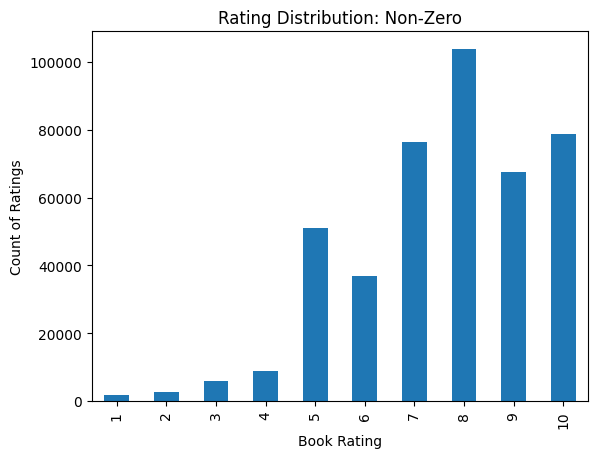

In [15]:
ratings_non_zero = ratings[ratings['bookRating'] > 0].reset_index(inplace=False,drop=True)
ratings_non_zero['bookRating'].value_counts(sort=False).sort_index().plot(kind='bar')
plt.title('Rating Distribution: Non-Zero')
plt.xlabel('Book Rating')
plt.ylabel('Count of Ratings')
plt.show()

<h3> Finding:</h3> 
<i>The Lovely Bones: A Novel</i> is now our top-rated and when compared to Amazon's review rating it is scored as 8.8/10 which is close to the 8.1/10 below. <br>
<i> Wild Animus</i> however went from 1/10 to 4.4/10 which is not as close to the 7/10 we identified earlier. <br><br>
My goal however is not to match the Amazon review ratings, but simply to adjust the dataframe to provide more realistic results.<br>
Since this change has accomplished that, I will proceed with this adjustment.
</h3>

In [16]:
rating_count_non_zero = pd.DataFrame(ratings_non_zero.groupby('ISBN')['bookRating'].count())
rating_count_non_zero['averageRating'] = pd.DataFrame(ratings_non_zero.groupby('ISBN')['bookRating'].mean())
most_rated_books_summary = pd.merge(rating_count_non_zero, books, on='ISBN')
most_rated_books_summary[most_rated_books_summary.columns[:5]].sort_values('bookRating',ascending=False).head()

,ISBN,bookRating,averageRating,bookTitle,bookAuthor
21513,0316666343,707,8.185290,The Lovely Bones: A Novel,Alice Sebold
115488,0971880107,581,4.390706,Wild Animus,Rich Shapero
38171,0385504209,487,8.435318,The Da Vinci Code,Dan Brown
17674,0312195516,383,8.182768,The Red Tent (Bestselling Backlist),Anita Diamant
4048,0060928336,320,7.887500,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells


<p> Next I'll be looking at the proportion of books with less than 10 ratings. <br>
A low review count will not provide a representative view of a books quality. </p>
<h3> Finding:</h3>
<p> I've identified that ~97% of books have less than 10 ratings. Since this is a small scale effort, I am okay with filtering out books with a low review count to save space and allow for the model to focus on books with more reviews.<br></p>

In [17]:
isbn_counts = ratings_non_zero['ISBN'].value_counts()

rating_entries = 10
isbn_counts_less_than = len(isbn_counts[isbn_counts < rating_entries])

print(f"Number of ISBNs with less than {rating_entries} ratings: {isbn_counts_less_than}")
print(f"Total number of ISBNs with a rating: {len(isbn_counts)}")
print(f"% of ISBN's with less than {rating_entries} ratings: {((isbn_counts_less_than / len(isbn_counts))*100):.4}%")


Number of ISBNs with less than 10 ratings: 180328
Total number of ISBNs with a rating: 185973
% of ISBN's with less than 10 ratings: 96.96%


<p> The refined dataframe has now gone from 1.1M records to 304K. I believe this will be a good size to feed into the recommendation system </p>

In [18]:
isbn_counts_more_than_1 = isbn_counts[isbn_counts > 1]
valid_isbns = isbn_counts_more_than_1.index.tolist()
filtered_df = ratings_non_zero[ratings_non_zero['ISBN'].isin(valid_isbns)]
filtered_df.shape

(304050, 3)

# 2. Prepare to feed data into model
<hr>

In [28]:
from scipy.sparse import csr_matrix

In [23]:
def clean_df(df):
    df = df[df['bookRating'] > 0].reset_index(inplace=False,drop=True)
    isbn_counts = df['ISBN'].value_counts() # Identifies Unique Book Entries
    isbn_counts_over_1 = isbn_counts[isbn_counts >= 10] # Books equal or with more than 10 rating are stored
    valid_isbns = isbn_counts_over_1.index.tolist() # Rearranged into a list

    df = df[df['ISBN'].isin(valid_isbns)] # Filter df
    return df

In [25]:
rating_df = clean_df(ratings)
print(f"""Shape of Ratings:\n{rating_df.shape} \n\nRatings Data Types: \n{rating_df.dtypes} \n\nRatings DF:\n{rating_df.head()}""")

Shape of Ratings:
(136290, 3) 

Ratings Data Types: 
userID         int64
ISBN          object
bookRating     int64
dtype: object 

Ratings DF:
    userID        ISBN  bookRating
5   276744  038550120X           7
7   276747  0060517794           9
8   276747  0671537458           9
9   276747  0679776818           8
14  276754  0684867621           8


In [36]:
combine_book_rating = pd.merge(rating_df, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating

,userID,ISBN,bookRating,bookTitle
0,276744,038550120X,7,A Painted House
1,11676,038550120X,10,A Painted House
2,16877,038550120X,9,A Painted House
3,17975,038550120X,6,A Painted House
4,20806,038550120X,6,A Painted House
...,...,...,...,...
132731,181687,0452283795,8,Wanderlust
132732,223087,0452283795,6,Wanderlust
132733,235935,0452283795,9,Wanderlust
132734,268932,0452283795,9,Wanderlust


In [29]:
combine_book_rating = combine_book_rating.drop_duplicates(['userID', 'bookTitle'])
rating_pivot = combine_book_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
rating_matrix = csr_matrix(rating_pivot.values)

In [33]:
rating_pivot

userID,9,16,17,19,26,32,39,42,44,51,...,278824,278828,278832,278836,278843,278844,278846,278849,278851,278854
bookTitle,,,,,,,,,,,,,,,,,,,,,
'Salem's Lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"14,000 Things to Be Happy About",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"\O\"" Is for Outlaw""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Fit a KNN model using Cosine Similarity & Evaluate 
<p>Now that the data is prepared, we will fit the model and return a top 5 recommendation list</p>

In [37]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [71]:
query_index = 3308 #np.random.choice(rating_pivot.shape[0]) # Just for consistency, I'm going to keep one specific sample
distances, indices = model_knn.kneighbors(rating_pivot.iloc[3308, :].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(rating_pivot.index[3308]))
    else:
        print('{0}: {1}, with distance of {2:.4}:'.format(i, rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The Green Mile: Coffey's Hands (Green Mile Series):

1: The Green Mile: Night Journey (Green Mile Series), with distance of 0.272:
2: The Green Mile: The Mouse on the Mile (Green Mile Series), with distance of 0.3103:
3: The Green Mile: The Bad Death of Eduard Delacroix (Green Mile Series), with distance of 0.3286:
4: The Two Dead Girls (Green Mile Series), with distance of 0.3398:
5: The Green Mile: Coffey on the Mile (Green Mile Series), with distance of 0.3808:


<h1>Conclusion:</h1>
<p> The goal of this project was to build a book recommendation system, this was accomplished by: <br>
<ol>
<li>Gathering a dataset with user ratings for books</li>
<li>Cleaning the data to ensure a reliable dataset</li>
<li>Establishing a Nearest Neighbor model using Cosine Similarly</li>
<li>Calling from the model to list the top 5 recommendations based on a selected book</li>
</ol></p>

<h2>Next Goals:</h2>
<ul>
<li>I would like to feed this model into a website where a user can search or select a book and see the recommendations for it</li>
<li>Create a visual chart for top books for a given Country (ex. Canadian Charts or US Charts) </li>
<li>Create a hybrid model using both collaborative and Content-based filtering </li>
